## Libraries

In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm_notebook
import pandas as pd
import cv2
import os
import pickle
from IPython.display import clear_output

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions

from os import listdir
from os import path

#Preprocessing
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#VGG
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input

from numpy import array
from pickle import load

#Layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint

## Extracting features from Images

In [61]:
SAMPLE_SIZE = 100

In [62]:
def extract_features(directory, num_samples=None):
    # loading VGG model weights
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    #model.summary()
    
    features = dict()
    files = listdir(directory)
    files = files if num_samples is None else files[:num_samples]
    for name in tqdm_notebook(files):
        # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # extracting features using VGG16
        feature = model.predict(image)
        
        # get image id
        image_id = name.split('.')[0]
        features[image_id] = feature
        
    return features

directory = './Flickr8k_Dataset/Flicker8k_Dataset'
grand_features = extract_features(directory, SAMPLE_SIZE)

print('Number of samples : {}'.format(len(grand_features)))
print("Shape of each image feature matrix: {}".format(grand_features[list(grand_features.keys())[0]].shape))

# saving on disk
from pickle import dump
dump(grand_features, open("features.pkl", "wb"))
print("Saved features on disk")

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Number of samples : 100
Shape of each image feature matrix: (1, 7, 7, 512)
Saved features on disk


## Text Data Preparation

In [64]:
import string
import re

In [65]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [66]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
doc[:300]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the s'

In [67]:
from collections import defaultdict

In [68]:
def get_image_ids():
    return set(grand_features.keys())

def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        
        if len(line) < 2:
            continue
        
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # remove filename from image id
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        
        # fetching those image ids for which we have extracted the features
        image_ids_with_features = get_image_ids()
        
        # create the list if needed
        # TODO : Include all the descriptions and not just the first one 
        if image_id not in mapping and image_id in image_ids_with_features :
            mapping[image_id] = list()
            # store description
            mapping[image_id].append(image_desc)
            
    return mapping

In [69]:
descriptions = load_descriptions(doc)
descriptions

{'1003163366_44323f5815': ['A man lays on a bench while his dog sits by him .'],
 '109738763_90541ef30d': ['A person on a snowmobile in mid jump .'],
 '111766423_4522d36e56': ["A black and white bird eating seeds out of someone 's hand"],
 '118309463_a532b75be9': ['A boys baseball team wear their uniforms .'],
 '1255504166_f2437febcb': ['A boy playing in a lake'],
 '1389323170_d1c81d6b51': ['a lone woman sitting on an usual green bench with a cup in her hand'],
 '1412832223_99e8b4701a': ['A child jumps on a sand dune .'],
 '1675679141_36c9bc2969': ['A jacketed man with his back to the camera is overlooking the water .'],
 '1794818900_e0ffdd268e': ['A girl plays on a red toy .'],
 '2066241589_b80e9f676c': ['A black and brown dog is biting on a stick in the forest .'],
 '2100735137_05c6079537': ['A little boy jumps on a toy air gun .'],
 '2225241766_f1e7132e3e': ['A man in jeans lying down on a pole outdoors .'],
 '2293149170_38fb2257ea': ['A boy is lying down in midst of many soft toys 

In [70]:
def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = ' '.join(desc)

In [71]:
clean_descriptions(descriptions)
descriptions

{'1003163366_44323f5815': ['man lays on bench while his dog sits by him'],
 '109738763_90541ef30d': ['person on snowmobile in mid jump'],
 '111766423_4522d36e56': ['black and white bird eating seeds out of someone hand'],
 '118309463_a532b75be9': ['boys baseball team wear their uniforms'],
 '1255504166_f2437febcb': ['boy playing in lake'],
 '1389323170_d1c81d6b51': ['lone woman sitting on an usual green bench with cup in her hand'],
 '1412832223_99e8b4701a': ['child jumps on sand dune'],
 '1675679141_36c9bc2969': ['jacketed man with his back to the camera is overlooking the water'],
 '1794818900_e0ffdd268e': ['girl plays on red toy'],
 '2066241589_b80e9f676c': ['black and brown dog is biting on stick in the forest'],
 '2100735137_05c6079537': ['little boy jumps on toy air gun'],
 '2225241766_f1e7132e3e': ['man in jeans lying down on pole outdoors'],
 '2293149170_38fb2257ea': ['boy is lying down in midst of many soft toys and spiderman quilt'],
 '2319197581_94f807b204': ['fluffy white d

In [72]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = to_vocabulary(descriptions)

In [73]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [74]:
def driver():
    filename = 'Flickr8k_text/Flickr8k.token.txt'
    doc = load_doc(filename)
    # parse descriptions
    descriptions = load_descriptions(doc)
    print('Loaded: %d ' % len(descriptions))
    # clean descriptions
    clean_descriptions(descriptions)
    # summarize vocabulary
    vocabulary = to_vocabulary(descriptions)
    print('Vocabulary Size: %d' % len(vocabulary))
    # save to file
    save_descriptions(descriptions, 'descriptions.txt')
driver()

Loaded: 100 
Vocabulary Size: 380


## Loading the prepared data : Train and Test Sets

In [75]:
from pickle import load
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
                # TODO : Use defaultdict instead
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc) # each id will have multiple descriptions
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset if k in all_features}
    return features

In [76]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=75
Photos: train=75


In [77]:
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
dev = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
dev_descriptions = load_clean_descriptions('descriptions.txt', dev)
print('Descriptions: test=%d' % len(dev_descriptions))

# photo features
dev_features = load_photo_features('features.pkl', dev)
print('Photos: test=%d' % len(dev_features))

Dataset: 6000
Descriptions: test=16
Photos: test=16


In [122]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 6000
Descriptions: test=7
Photos: test=7


In [80]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [81]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare train sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions,
train_features)
# prepare test sequences
X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions,
dev_features)

Vocabulary Size: 301
Description Length: 25


## Defining the model

In [52]:
embedding_size = 300
inp = Input(shape=(7,7,512))
inp1 = Conv2D(512, (3,3), activation='relu')(inp)
inp11 = MaxPooling2D(pool_size=(2, 2))(inp1)
inp2 = Flatten()(inp11)

In [82]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(7,7,512))
    inp1 = Conv2D(512, (3,3), activation='relu')(inputs1)
    inp11 = MaxPooling2D(pool_size=(2, 2))(inp1)
    inp2 = Flatten()(inp11)
    
    #inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inp2)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [91]:
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,
save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=5, verbose=2, callbacks=[checkpoint],
validation_data=([X1dev, X2dev], ydev))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 5, 5, 512)    2359808     input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 2, 2, 512)    0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 25)]         0                                            
____________________________________________________________________________________________

## Prediction

In [93]:
from numpy import argmax
from pickle import load
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [111]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [96]:
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for _ in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
        return in_text

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [120]:
# load the model
filename = 'model.h5'
model = load_model(filename)

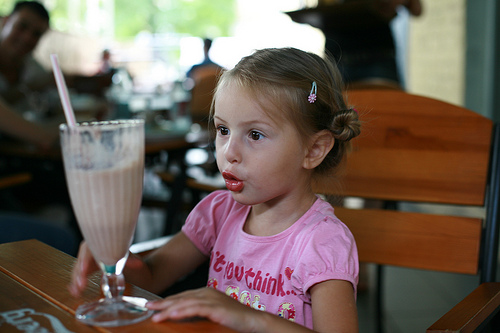

In [123]:
from PIL import Image
test_sample = np.random.choice(list(test_features.keys()))
Image.open('./Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg'.format(test_sample))

In [125]:
sample_features = test_features[test_sample]
pred = generate_desc(model, tokenizer, sample_features, max_length)
cleanup_summary(pred)

'comes'